In [184]:
import pandas as pd
import obspy 
import os
import re
import logging
from datetime import datetime

In [189]:
paths = os.listdir("data/2023/01/01") 

folders =  os.listdir("data/2023/") 

letters = 'CN.PPPP'

with_s = [x for x in paths if re.match(r'^{}'.format(letters), x)]

folders

['01', '02', '03', '04', '05', '06', '07', '08', '09', '11', '12']

In [53]:
len(with_s)

24

In [54]:
with_s

['CN.PPPP._20230101_000000.seed',
 'CN.PPPP._20230101_010000.seed',
 'CN.PPPP._20230101_020000.seed',
 'CN.PPPP._20230101_030000.seed',
 'CN.PPPP._20230101_040000.seed',
 'CN.PPPP._20230101_050000.seed',
 'CN.PPPP._20230101_060000.seed',
 'CN.PPPP._20230101_070000.seed',
 'CN.PPPP._20230101_080000.seed',
 'CN.PPPP._20230101_090000.seed',
 'CN.PPPP._20230101_100000.seed',
 'CN.PPPP._20230101_110000.seed',
 'CN.PPPP._20230101_120000.seed',
 'CN.PPPP._20230101_130000.seed',
 'CN.PPPP._20230101_140000.seed',
 'CN.PPPP._20230101_150000.seed',
 'CN.PPPP._20230101_160000.seed',
 'CN.PPPP._20230101_170000.seed',
 'CN.PPPP._20230101_180000.seed',
 'CN.PPPP._20230101_190000.seed',
 'CN.PPPP._20230101_200000.seed',
 'CN.PPPP._20230101_210000.seed',
 'CN.PPPP._20230101_220000.seed',
 'CN.PPPP._20230101_230000.seed']

In [178]:
def data_day_processing(Year,Month,Day):
    paths = os.listdir("data/"+Year+"/"+Month+"/"+Day)
    paths_PPPP = [x for x in paths if re.match(r'^{}'.format('CN.PPPP'), x)]
    bandera = True
    if len(paths_PPPP)==24:
        k = 1
        for i in paths_PPPP:
            st = obspy.read("data/"+Year+"/"+Month+"/"+Day+"/"+i)
            st = st.select(component='Z')
            if len(st)==1:
                if k == 1:
                    st_final = st[0].resample(sampling_rate = 100)
                else:
                    st_final = st_final + st[0].resample(sampling_rate = 100)
                k = k+1
            else:
                bandera = False
                logging.error("No hay componente Z en el archivo "+i)
        
        if bandera:
            st_final.write("data/clean_data/2023/CN_PPPP_HHZ_"+Year+Month+Day+".sac", format = 'sac')   
    else:
        logging.error("El día no está completo en el día "+Year+"_"+Month+"_"+Day)            
            

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


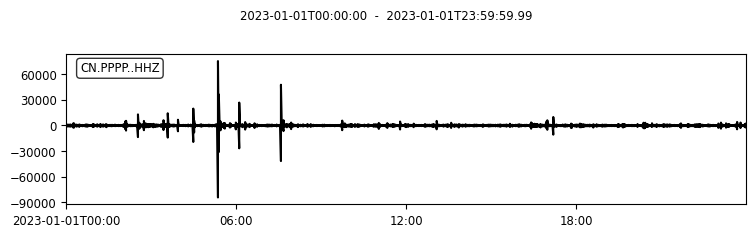

In [167]:
data_day_processing('2023','01','01')

In [151]:
st.stats

         network: CN
         station: PPPP
        location: 
         channel: HHZ
       starttime: 2023-01-01T00:00:00.000000Z
         endtime: 2023-01-01T23:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 8640000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1764, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 2737152})
      processing: ["ObsPy 1.4.1: resample(no_filter=True::sampling_rate=100::strict_length=False::window='hann')"]

In [169]:
st = obspy.read("data/clean_data/2023/CN_PPPP_HHZ_20230101.sac")

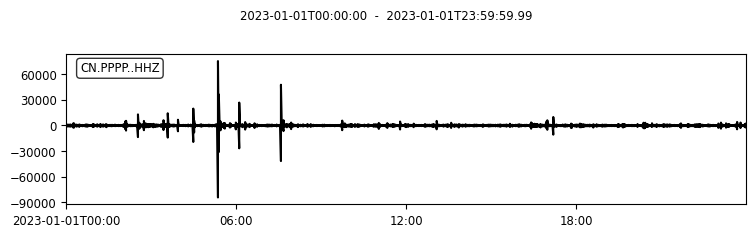

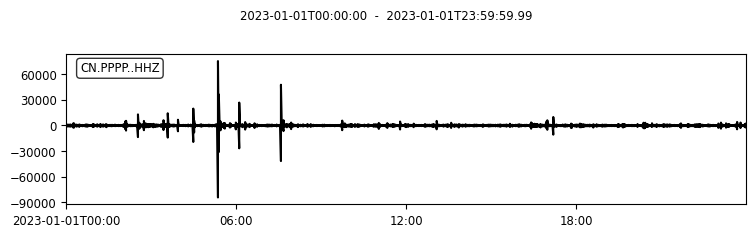

In [175]:
st[0].plot()

In [176]:
st = obspy.read("data/2023/01/01/CN.PPPP._20230101_000000.seed")
st2 = obspy.read("data/2023/01/01/CN.PPPP._20230101_020000.seed")

#st_vacio = obspy.Stream.clear

#st_vacio

#st[2]+st_vacio

st2 = st.select(component='Z')

st2[0].resample(sampling_rate = 100).data.dtype


#st2.plot()
#st2.stats

#st2 = st[2]
#st2.stats 
#st[2].data.dtype

dtype('float64')

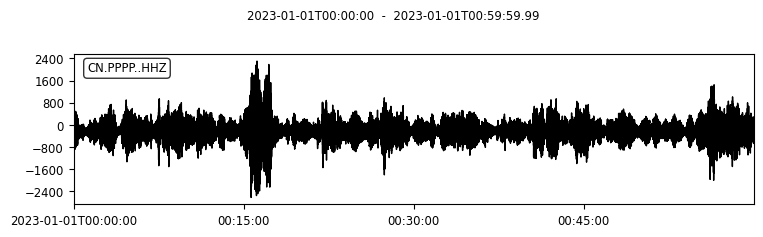

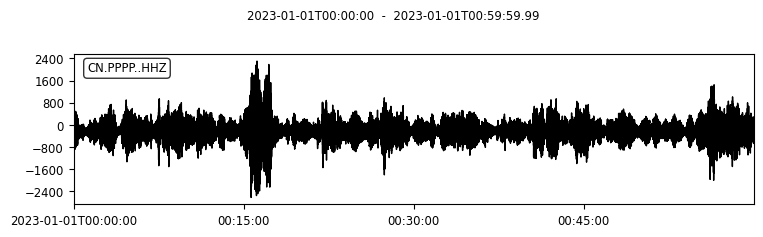

In [177]:
st[2].stats

st[2].data.dtype

st[2].plot()


In [50]:
st_hz = (st[2]+st2[2]).resample(sampling_rate=100)
st_hz.stats

#st3_hz = st_hz+st2_hz

         network: CN
         station: PPPP
        location: 
         channel: HHZ
       starttime: 2023-01-01T00:00:00.000000Z
         endtime: 2023-01-01T02:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 1080000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1764, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 2737152})
      processing: ["ObsPy 1.4.1: resample(no_filter=True::sampling_rate=100::strict_length=False::window='hann')"]

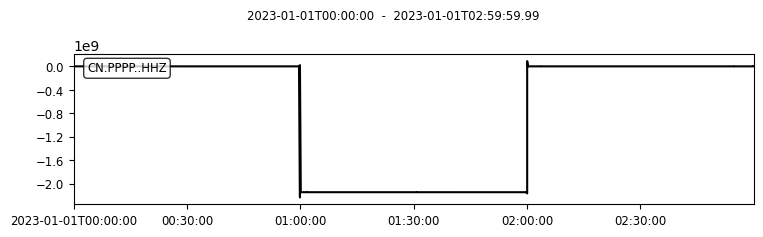

c:\Users\LENOVO\OneDrive\Documentos\Estancia de Investigación\Estancia_Maestría\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


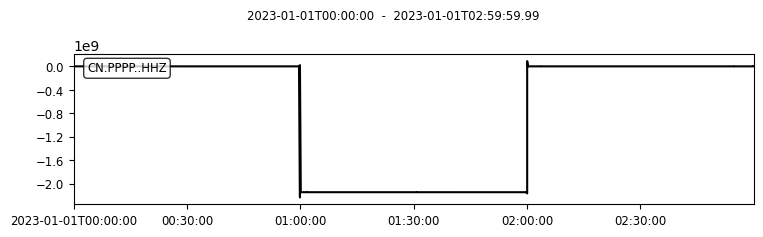

In [51]:
st_hz.plot()

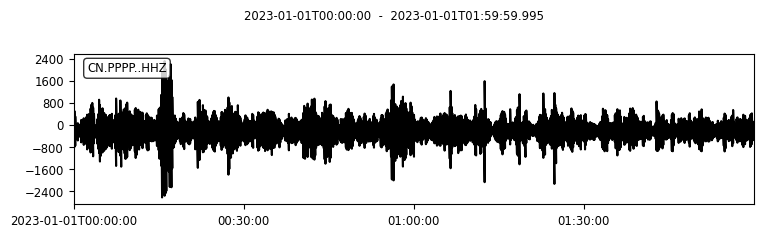

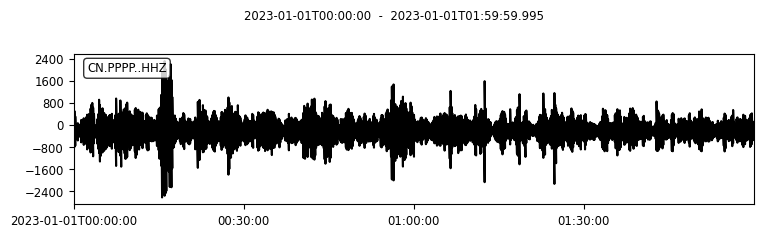

In [22]:
st3_hz.plot()

In [14]:
st_hz_smple = st_hz.copy()

In [23]:
st_hz_smple.resample(sampling_rate=100)

CN.PPPP..HHZ | 2023-01-01T00:00:00.000000Z - 2023-01-01T00:59:59.990000Z | 100.0 Hz, 360000 samples

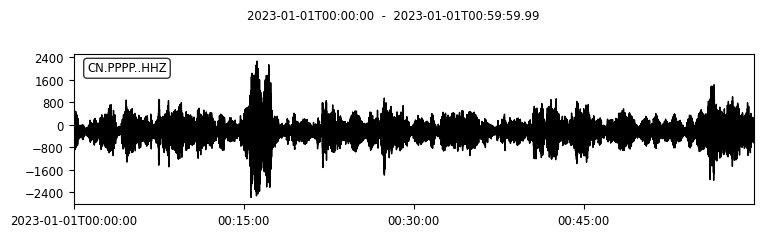

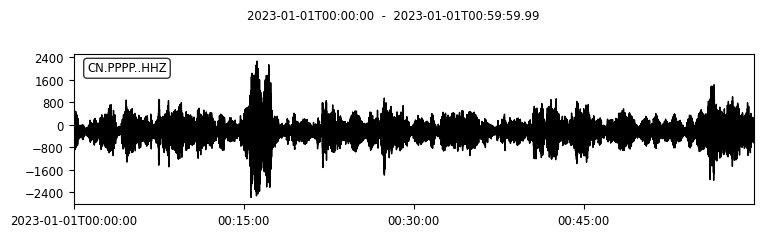

In [24]:
st_hz_smple.plot()

In [191]:
st = obspy.read("data/clean_data/2022/CN_PPPP_HHZ_20220101.sac")
st2 = obspy.read("data/clean_data/2022/CN_PPPP_HHZ_20220102.sac")

In [194]:
st2[0].stats

         network: CN
         station: PPPP
        location: 
         channel: HHZ
       starttime: 2022-01-02T00:00:00.000000Z
         endtime: 2022-01-02T23:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 8640000
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.01, 'depmin': -40215.035, 'depmax': 32849.82, 'scale': 1.0, 'b': 0.0, 'e': 86399.984, 'depmen': -226.88959, 'nzyear': 2022, 'nzjday': 2, 'nzhour': 0, 'nzmin': 0, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 8640000, 'iftype': 1, 'iztype': 9, 'leven': 1, 'lpspol': 1, 'lovrok': 1, 'lcalda': 0, 'kstnm': 'PPPP', 'kcmpnm': 'HHZ', 'knetwk': 'CN'})